In [63]:
# EDA + Data Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 결측치 대체
from sklearn.preprocessing import Imputer

# Scaling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Warning 무시
import warnings
warnings.filterwarnings("ignore")

# 한 셀에서 여러 output 한번에 표시
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#  
#  
#  
#  
# 1. Preparing Dataset

In [64]:
# Data 불러오기Data 불러오기
data_df = pd.read_csv('titanic.csv')

# y 데이터 정의하기
y_data = data_df[['Survived']]

# x 데이터 정의하기
del data_df['Survived']
x_data = data_df

#  
#  
#  
#  
# 2. Data Processing (= Feature engineering & selection)

##### 결측치 대체

In [81]:
data_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [65]:
# Emarked 열 결측치 대체 (최빈값으로, str → int)
data_df[['Embarked']] = data_df[['Embarked']].replace({'S':1, 'C':2, 'Q':3})
mode_imp = Imputer(strategy = 'most_frequent', axis =0)
data_df['Embarked'] = mode_imp.fit_transform(data_df[['Embarked']])

In [66]:
# Age 열 결측치 대체 (Name Initial 기준 평균값으로)

data_df["Name_initial"] = data_df["Name"].str.extract("([A-Za-z]+)\.",expand=False)
# 정규표현식 : '하나 이상의 대소문자 뒤 소수점'을 찾아 괄호부분을 기억해라(출력해라)

data_df_new = data_df.copy()
data_df_new = data_df_new.drop("Name",axis=1)

data_df_new["Name_initial"] = data_df_new["Name_initial"].replace(["Dr","Rev","Major","Col","Capt","Don","Countess","Sir","Lady","Jonkheer","Ms"], 'etc')
data_df_new["Name_initial"] = data_df_new["Name_initial"].replace("Mme", "Mrs")
data_df_new["Name_initial"] = data_df_new["Name_initial"].replace("Mlle", "Miss")


for i in list(set(data_df_new["Name_initial"].values)) :
    data_df_new.loc[(data_df_new.Age.isnull())&(data_df_new.Name_initial== i ),'Age'] = data_df_new.groupby('Name_initial')['Age'].mean()[i]
    
# list(set(x_data_new["Name_initial"].values)) = ['etc', 'Mrs', 'Miss', 'Master', 'Mr']
# x_data_new.groupby('Name_initial')['Age'].mean()["Miss"] = 21.804

data_df["Age"] = data_df_new["Age"].round()


# null check
data_df.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          0
Name_initial      0
dtype: int64

In [67]:
# Family 열 추가 (SibSp + Parch)
data_df["Family"] = data_df["SibSp"] + data_df["Parch"]
data_df = data_df.drop(["SibSp","Parch"],axis=1)

# 가중치 열 추가

In [68]:
# Sex 변환 : str → int
data_df[['Sex']] = data_df[['Sex']].replace({'male':0 , 'female':1})

In [69]:
# 불필요 열 제거
data_df = data_df.drop(['PassengerId', 'Cabin', 'Ticket', 'Name', 'Name_initial'], axis=1)

In [70]:
x_data = data_df

# 확인하기
x_data.head(3)
y_data.head(3)

,Pclass,Sex,Age,Fare,Embarked,Family
0,3,0,22.0,7.2500,1.0,1
1,1,1,38.0,71.2833,2.0,1
2,3,1,26.0,7.9250,1.0,0


,Survived
0,0
1,1
2,1


In [71]:
# Standardization (Age, Fare)
# standard = StandardScaler().fit(x_data[['Age', 'Fare']])
# x_data[['Age', 'Fare']] = standard.transform(x_data[['Age', 'Fare']])

# MinMax (Age, Fare)
minmax = MinMaxScaler().fit(x_data[['Age', 'Fare']])
x_data[['Age', 'Fare']] = minmax.transform(x_data[['Age', 'Fare']])


In [72]:
# One-hot Encoding (Pclass, Embarked, Sex)

x_data = pd.get_dummies(x_data, columns=['Pclass', 'Sex', 'Embarked'])
x_data.head(3)

,Age,Fare,Family,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_1.0,Embarked_2.0,Embarked_3.0
0,0.275,0.014151,1,0,0,1,1,0,1,0,0
1,0.475,0.139136,1,1,0,0,0,1,0,1,0
2,0.325,0.015469,0,0,0,1,0,1,1,0,0


In [73]:
titanic_data = np.array(x_data)
titanic_target = np.array(y_data)

titanic_X = titanic_data
titanic_Y = titanic_target

#  
#  
#  
#  
# 4. Train-Test Split (비율은 7:3, seed=0)

In [74]:
from sklearn import model_selection

x_train, x_test, y_train, y_test = model_selection.train_test_split(titanic_X, titanic_Y, test_size=0.3, random_state=0)

#  
#  
#  
#  
# 5. Training → Predicting

In [75]:
# 머신러닝 모델 라이브러리 import
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors, datasets
from sklearn import datasets, ensemble

# 정확도
from sklearn.metrics import accuracy_score

# 그리드 서치
from sklearn.model_selection import GridSearchCV

In [76]:
# 로지스틱 리그레션

lr = LogisticRegression(random_state= 13, solver='liblinear')
lr.fit(x_train, y_train)

lr_pred = lr.predict(x_test)
print(accuracy_score(y_test, lr_pred))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=13, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

0.8059701492537313


In [77]:
from sklearn.model_selection import GridSearchCV

rf_param = {'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,16,20],
    'min_samples_split':[8,16,20] }

rf_grid = GridSearchCV(rf, rf_param, cv=2, return_train_score=True)
rf_grid.fit(x_train, y_train)
test_score = rf_grid.score(x_test, y_test)

print("테스트 세트 점수: {:.2f}".format( test_score ))
print("최적 매개변수: {}".format(rf_grid.best_params_))
print("최고 교차 검증 점수: {:.4f}".format(rf_grid.best_score_))

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=400,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='war

테스트 세트 점수: 0.80
최적 매개변수: {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}
최고 교차 검증 점수: 0.7913


In [78]:
# 랜덤포레스트

rf = RandomForestClassifier(n_estimators=10, max_depth=400)
rf.fit(x_train, y_train)

rf_pred = rf.predict(x_test)
print(accuracy_score(y_test, rf_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=400, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

0.8097014925373134


In [79]:
# SVC
model = SVC()

# SVC 그리드 서치
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100] }

grid_search = GridSearchCV(model, param_grid, cv=5, return_train_score=True)
grid_search.fit(x_train, y_train)
test_score = grid_search.score(x_test, y_test)

print("테스트 세트 점수: {:.2f}".format( test_score ))
print("최적 매개변수: {}".format(grid_search.best_params_))
print("최고 교차 검증 점수: {:.4f}".format(grid_search.best_score_))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

테스트 세트 점수: 0.80
최적 매개변수: {'C': 100, 'gamma': 0.01}
최고 교차 검증 점수: 0.8122


In [125]:
# svc.fit(x_train, y_train)

# svc = SVC(C=10, gamma=0.1)
# print("Accuracy on Training set: {:.3f}".format(svc.score(x_train, y_train)))
# print("Accuracy on Test set: {:.3f}".format(svc.score(x_test, y_test)))

In [80]:
gb_param = {'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,16,20],
    'min_samples_split':[8,16,20] }

gb_grid = GridSearchCV(gb, gb_param, cv=5, return_train_score=True)
gb_grid.fit(x_train, y_train)
test_score = gb_grid.score(x_test, y_test)

print("테스트 세트 점수: {:.2f}".format( test_score ))
print("최적 매개변수: {}".format(gb_grid.best_params_))
print("최고 교차 검증 점수: {:.4f}".format(gb_grid.best_score_))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.01,
                                                  loss='deviance', max_depth=4,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=5,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=1000,
                                                  n_iter_no_change=None,
                                                  presor

테스트 세트 점수: 0.82
최적 매개변수: {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 교차 검증 점수: 0.8170


In [19]:
# Gradient Boosting

params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01}

gb = ensemble.GradientBoostingClassifier(**params)
gb.fit(x_train, y_train)

acc = accuracy_score(y_test, gb.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

The accuracy score on test set: 0.8209


<Figure size 720x720 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

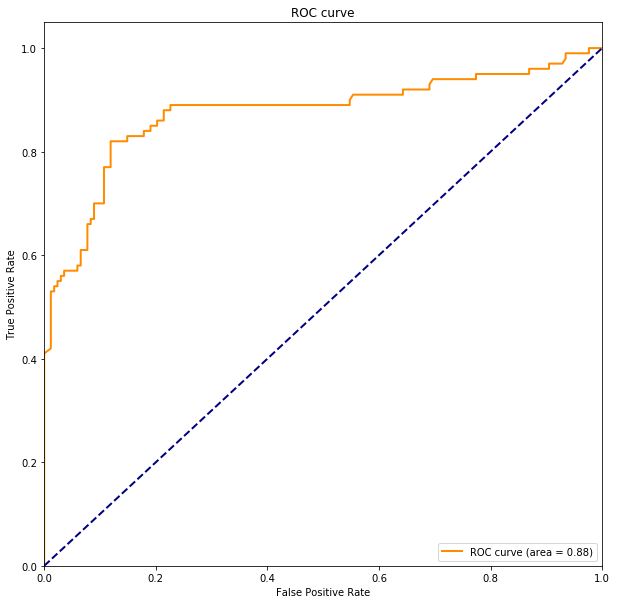

In [59]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=gb.predict_proba(x_test)[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

# 디카프리오, 케이트 윈슬렛 생존율 구하기

In [113]:
decaprio = np.array([[3, 0, 18, 5, 3, 0]])
print('Decaprio :', rf.predict_proba(decaprio)[0, 1])

winslet = np.array([[1, 1, 16, 100, 3, 1]])
print('Winslet :', rf.predict_proba(winslet)[0, 1])

jiyoon = np.array([[1, 1, 26, 30, 3, 0]])
print('Jiyoon :', rf.predict_proba(winslet)[0, 1])

Decaprio : 0.3044621017913652
Winslet : 0.8097938289817335
Jiyoon : 0.8141637517723823
